# Vehicle Detector

The goal of this project is to generate a succesful pipeline that allows to detect cars from image and video taken from a camera placed on the front center of a car.

The steps to achieve the goal are:

1. Find a dataset of cars and non-cars images to train a Linear SVM with a test accuracy greater than 96% when finding car from images 
2. Analyze the data visually to understand the features to extract
3. Process images and extract features from them. In this case, the chosen feature extraction methods are:
    * Color Histogram features extraction
    * Spatial features extraction
    * Histogram of Orientation Gradient (HOG)
4. Train the linear SVM with the extracted features and verify its test accuracy is greater than 96%
5. Implement a sliding window in images to look only in region of interst (ROI) for potential features that give a positive car prediction
6. Combine multiple detection and eliminate false positives by using a heat-map 
7. Create a pipeline with all the elements above and process video

At the very end a small discussion on improvements will describe in high level how the approach taken here can be improved

## 1. Dataset

The dataset used in here was taken from several places and compiled by Udacity into two datasets:
* [Vehicles_images](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip)
* [Non-vehicles images](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip)

** STANDARD Imports for PYTHON **

In [1]:
import numpy as np
import time
import cv2
import pickle

# Read an plot images
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

#HOG feature extractor
from skimage.feature import hog

# For the SVM classifier
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
#sklearn.model_selection exist only in sklearn 0.18. If using sklearn <= 0.17 use: 
#   from sklearn.cross_validation import train_test_split 

# For Heat-map functions
from scipy.ndimage.measurements import label

# For video editing and embedding in the jupyter Notebook
from moviepy.editor import VideoFileClip
from IPython.display import HTML

** CUSTOMIZED Imports created for this project **

In [2]:
import feature_extraction as fext
import SVMcar_classifier as carSVM #from SVMcar_classifier import *
import heatmap as hmap
import car_finder as carf

#from feature_extraction import *
#from heatmap import *
#from car_finder import *

Loading the data to show a brief summary of the data sets

In [3]:
cars, noncars = carSVM.load_dataset()
print("Cars' images:           {}".format(len(cars)))
print("Non-cars' images:       {}\n".format(len(noncars)))

index = np.random.randint(0,len(cars))
car_img = mpimg.imread(cars[index])
noncar_img = mpimg.imread(noncars[index])

print("Car image size:         {}x{}x{}".format(car_img.shape[0], car_img.shape[1], car_img.shape[2]))
print("Non-car image size:     {}x{}x{}\n".format(noncar_img.shape[0], noncar_img.shape[1], noncar_img.shape[2]))
print("Car image data type:    {}".format(car_img.dtype))
print("Noncar image data type: {}".format(noncar_img.dtype))


Cars' images:           8792
Non-cars' images:       8968

Car image size:         64x64x3
Non-car image size:     64x64x3

Car image data type:    float32
Noncar image data type: float32


## 2. Dataset Visualization

The first step was to explore the dataset and understand what kind of images we have

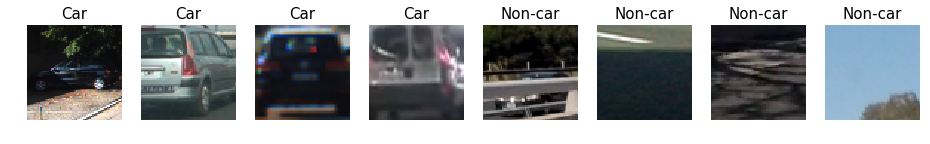

In [4]:
fig, axs = plt.subplots(1,8, figsize=(16, 2))

for i in np.arange(4):
    img = mpimg.imread(cars[np.random.randint(0,len(cars))])
    axs[i].axis('off')
    axs[i].set_title('Car', fontsize=15)
    axs[i].imshow(img)
for i in np.arange(4,8):
    img = mpimg.imread(noncars[np.random.randint(0,len(noncars))])
    axs[i].axis('off')
    axs[i].set_title('Non-car', fontsize=15)
    axs[i].imshow(img)
    plt.savefig('output_images/data_visualization.png', 
            bbox_inches="tight")

# 3. Feature Extraction

From the images above we can tell that cars have different colors and that they seem to have similar colors with images of non-cars. Thus, the extraction of color and HOG features can give a pattern close to find unique information in images that classifies something as car and non-car.

## 3.1. Color Histogram

Color features can be obtained using a color histogram from the whole image. The distribution of colors in the histogram can help us recognize what can be a car as particular colors are used for car and not in the road.

** IMPORTANT: **
The dataset for this project contains .png format images. 

Consideration for **.png images**:
* **_matplotlib image_** will read these **.png** images on a **scale of 0 to 1**. _Images are in **RGB**_
* **_cv2.imread()_** will scale **.png images from 0 to 255**. _Images are in **BGR**_

Consideration for **.jpg images**:
* **_matplotlib image_** will read these **.jpg** images in on a **scale of 0 to 255**. _Images are in **RGB**_
* **_cv2.imread()_** will scale **.jpg images from 0 to 255**. _Images are in **BGR**_

Consideration for **color space changes**:
* If you take an **image that is scaled from 0 to 1 and change color spaces using _cv2.cvtColor()_ you'll get back an image scaled from 0 to 255**.
* Summary for above:
    1. **Image scaled [0 to 1] **
    2. **Color space change the Image** using **_cv2.cvtColor()_** 
    3. **Returned Image** is **scaled [0 to 255]**

Thus, if you are switching between **_cv2.imread()_** and **_matplotlib image_** for reading images, scale them appropriately! Otherwise your feature vectors can behave weird and you will not get anything out of them. Be consistent between your training data features and inference features!


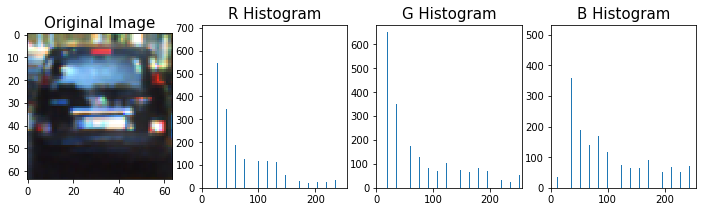

In [5]:
# Random index
index = np.random.randint(0, len(cars))
# Read in a dataset .png image using cv2.imread() to have a scale 0 to 255
img = cv2.imread(cars[index])
#  Image is in BGR, color convert to RGB
car_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Return features for visualization (normal operation return a single features vector)
channel1_hist, channel2_hist, channel3_hist, bin_centers  = fext.color_hist(car_img, vis_ret=True)

# Plot color features histogram
fig = plt.figure(figsize=(12,3));

plt.subplot(141)
plt.imshow(car_img)
plt.title('Original Image', fontsize=15)
plt.subplot(142)
plt.bar(bin_centers, channel1_hist[0])
plt.xlim(0, 256)
plt.title('R Histogram', fontsize=15);
plt.subplot(143)
plt.bar(bin_centers, channel2_hist[0])
plt.xlim(0, 256)
plt.title('G Histogram', fontsize=15);
plt.subplot(144)
plt.bar(bin_centers, channel3_hist[0])
plt.xlim(0, 256)
plt.title('B Histogram', fontsize=15);

plt.savefig('output_images/color_hist_vis.png', 
            bbox_inches="tight")


From the example above one can see that the color of the car corresponds to a more populated distribution with higher values in the histogram of the car's color. Thus, we can say color is a good feature to have, but it cannot be the only one as within a city there are many colors similar to cars. There is a need for more features that can be added to the color feature and give a better car-unique identification or feature.

There is also the need for verifying that if a car is to far off we still can recognize some of its features, so we can do a spatial feature extractor and see how the color behave in pictures that are smaller (low resolution).

## 3.2. Spatial Binning of Color Features

The spatial features will help to confirm that color features will not change even if the car image is a bit compressed or the car is far off and a low resolution picture is taken.

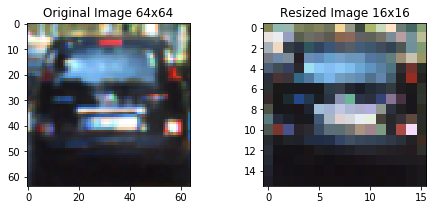

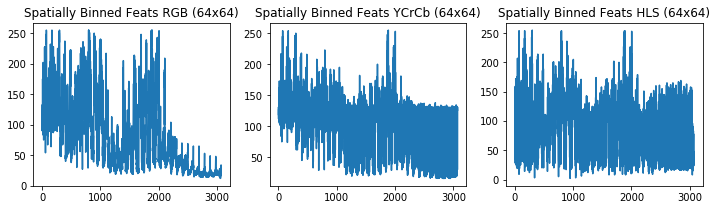

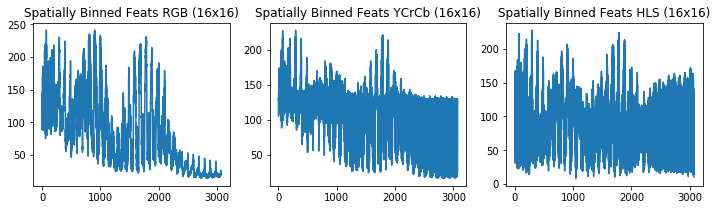

In [6]:
# Original image in BGR was converted above to RGB, convert to othwer color spaces
car_YCrCb = cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)
car_HLS = cv2.cvtColor(car_img, cv2.COLOR_RGB2HLS)

# Extract spatial features from original image
RGBspatial_feat   = fext.bin_spatial(car_img)
YCrCbspatial_feat = fext.bin_spatial(car_YCrCb)
HLSspatial_feat   = fext.bin_spatial(car_HLS)


# Create a lower resolution image
low_car_img = cv2.resize(car_img, (16,16))

# Color space change the low resolution image
low_car_YCrCb = cv2.cvtColor(low_car_img, cv2.COLOR_RGB2YCrCb)
low_car_HLS = cv2.cvtColor(low_car_img, cv2.COLOR_RGB2HLS)

# Extract spatial features from low resolution image
low_RGBspatial_feat   = fext.bin_spatial(low_car_img)
low_YCrCbspatial_feat = fext.bin_spatial(low_car_YCrCb)
low_HLSspatial_feat   = fext.bin_spatial(low_car_HLS)


# Plot the images
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(car_img)
plt.title('Original Image 64x64')
plt.subplot(132)
plt.imshow(low_car_img)
plt.title('Resized Image 16x16')
plt.savefig('output_images/bin_spatial_images.png', bbox_inches="tight")

# Plot the features for each image
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot(RGBspatial_feat)
plt.title('Spatially Binned Feats RGB (64x64)')
plt.subplot(132)
plt.plot(YCrCbspatial_feat)
plt.title('Spatially Binned Feats YCrCb (64x64)')
plt.subplot(133)
plt.plot(HLSspatial_feat)
plt.title('Spatially Binned Feats HLS (64x64)')
plt.savefig('output_images/bin_spatial_feats_original.png', bbox_inches="tight")

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot(low_RGBspatial_feat)
plt.title('Spatially Binned Feats RGB (16x16)')
plt.subplot(132)
plt.plot(low_YCrCbspatial_feat)
plt.title('Spatially Binned Feats YCrCb (16x16)')
plt.subplot(133)
plt.plot(low_HLSspatial_feat)
plt.title('Spatially Binned Feats HLS (16x16)')

plt.savefig('output_images/bin_spatial_feats_resized.png', bbox_inches="tight")

The spatial binning shows how RGB features remain very similar for the original and the low resolution images. It increases the features for YCrCb and HLS spaces, but they seem to have similar caracteristics. Thus, we can use a spatial binning to classify low resolution images.

## 3.3. Histogram of Orientation Gradient (HOG)

The color features seem to be a potential method for cars' detection, however, we need a method that is color independent. The method that allows such capability is a histogram of orientation gradient which will mainly give the shape of objects and is extensively used in computer vision. Extraction of HOG features will be key for our SVM to learn how to accurately detect cars.

It is **important** to know that the HOG can only be applied to a single color channel. A grayscale image is basically a single channel image and we will use that to extract the HOG in this example. Later on, the HOG will be applied to single channels, but not necessarily grayscale images.

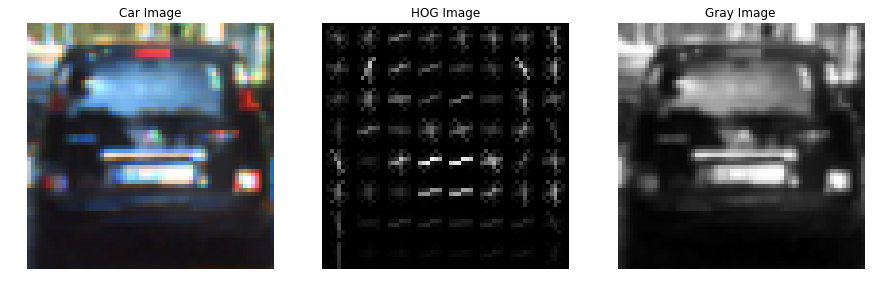

In [7]:
car_gray = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)

# HOG parameters and extraction
orient = 9
pix_per_cell = 8
cell_per_block = 2
feat_hog, hog_img = fext.get_hog_features(car_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot HOG
fig = plt.figure(figsize = (15,15))
plt.subplot(131)
plt.imshow(car_img, cmap='gray')
plt.title('Car Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(hog_img, cmap='gray')
plt.title('HOG Image')
plt.axis('off')
plt.subplot(133)
plt.imshow(car_gray, cmap='gray')
plt.title('Gray Image')
plt.axis('off')
plt.savefig('output_images/hog_img.png', 
            bbox_inches="tight")

The HOG image clearly shows that the orientation of the gradients follow the shapes of the image. This mean that we are extracting the HOG successfully and it can be color independent.

## 4. SVM Classifier

After extracting all features separately the concept for each was proven, however, all of them should be combined for a better training of the SVM.

The function *extract_features( )* in *features_extraction.py* combines all of the features in one single function. This function will be used to extract features and pass them to the SVM to learn to classify cars from non-cars.

In [8]:
# Extract features parameters 

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL" channels
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

carSVMclf, X_scalerSVM = carSVM.vehicle_classifier(color_space, orient, pix_per_cell, cell_per_block,
                          hog_channel, spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat,
                          return_svm=True)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
22.95 Seconds to train SVC...
Test Accuracy of SVC =  0.9887
Vehicle Detection classifier information saved.


The classifier has a test accuracy greater than 96% and that means we have trained successfully the SVM.


## 5. Sliding Window

The previous data manipulation and feature extraction used the Udacity's dataset and for images in the road and video streams of a road we will need to find cars in frames/images where there is more than one car or no cars at all.
In order to achieve that we need to create a sliding window technique that searches in the whole image for cars.

**Important reminder:** matplotlib image will read these .jpg images in on a scale of 0 to 255. Images are in RGB

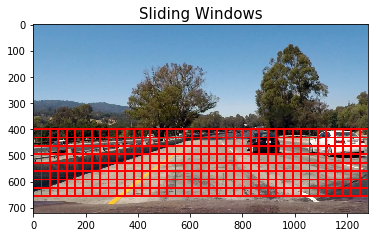

In [9]:
test_images_names = glob.glob('test_images/*.jpg')

test_images = []
for img in test_images_names:
    test_images.append(img)

test_img1 = mpimg.imread(test_images[0])
test_img2 = mpimg.imread(test_images[1])
test_img4 = mpimg.imread(test_images[3])

windows = fext.slide_window(test_img1, x_start_stop=[None, None], y_start_stop=[400, 660], 
                         xy_window=(64, 64), xy_overlap=(0.5, 0.5))

window_img = fext.draw_boxes(test_img1, windows, color=(255,0,0))

plt.imshow(window_img)
plt.title('Sliding Windows', fontsize=15);
plt.savefig('output_images/sliding_window.png', bbox_inches="tight")

After the slide window is implemented it is necessary to do a search in each window and predict if there is a car

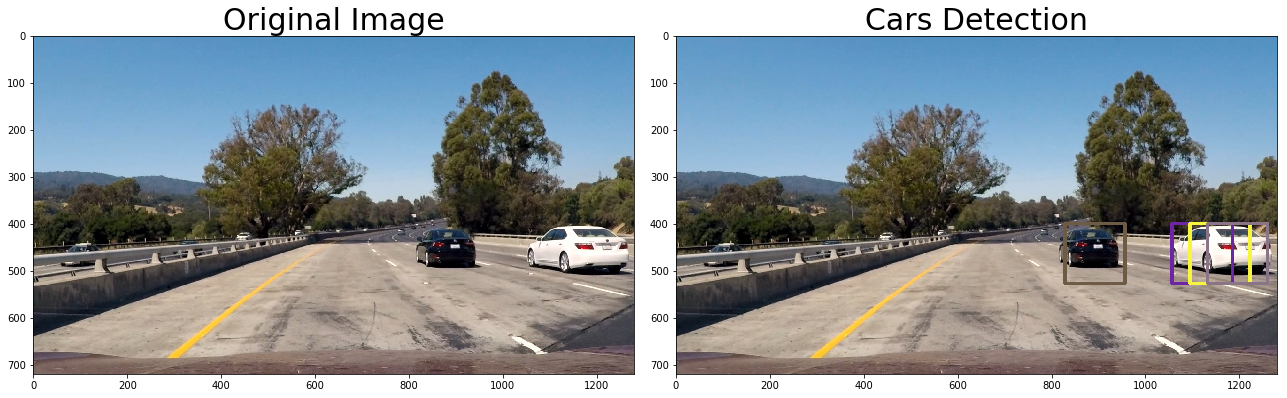

In [10]:
# Slide window sutmized for the detection
windows =  fext.slide_window(test_img1,
                            x_start_stop=[600, None],
                            y_start_stop=[400, 656],
                            xy_window=(128,128),
                            xy_overlap=(.7,.7))


# All parameters were defined while training the SVM
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = test_img1.astype(np.float32)/255 # helps scale picture to the scale used for SVM training

searched_windows = fext.search_windows(image, windows, carSVMclf, X_scalerSVM, color_space, 
                   spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                   spatial_feat, hist_feat, hog_feat)


detections_img = fext.draw_boxes(image, searched_windows, random_color=True) 
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
plt.tight_layout()
ax1.imshow(test_img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(detections_img)
ax2.set_title('Cars Detection', fontsize=30)
plt.savefig('output_images/cars_windows_detection.png', bbox_inches="tight")

## 6. Heatmap 

A single car can be detected by different windows and there can be false positives. Thus, we need to add a heat map technique to make the detection robust and to combine multiple detections into a single detection based on how many times a specific area in the picture was detected.

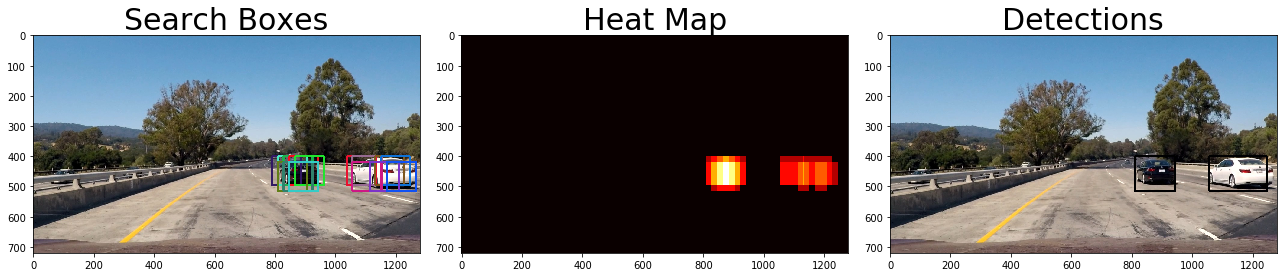

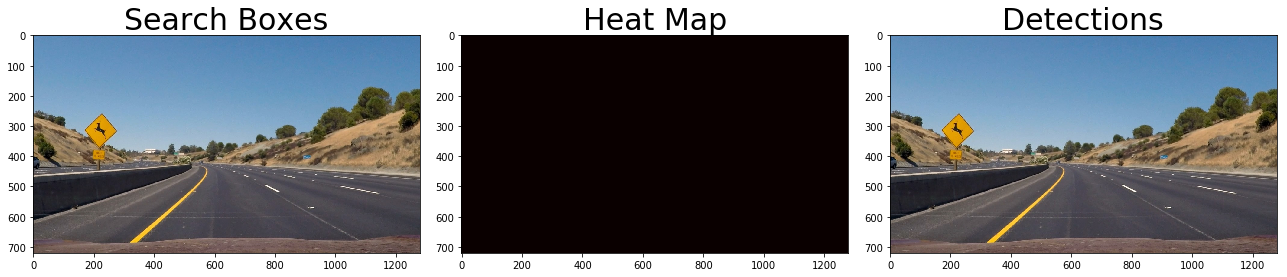

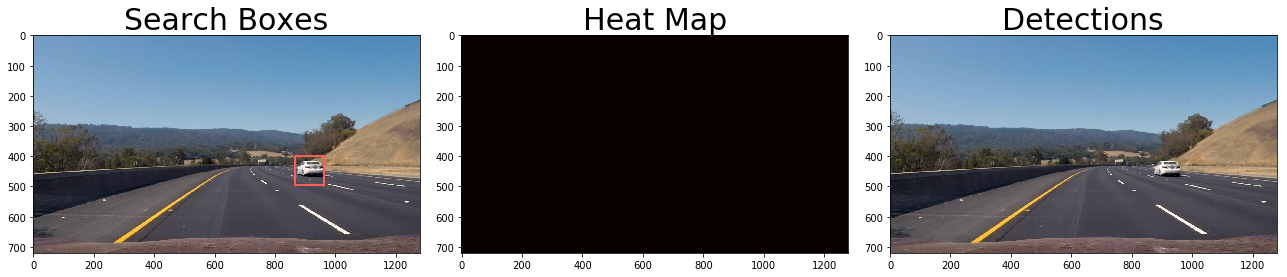

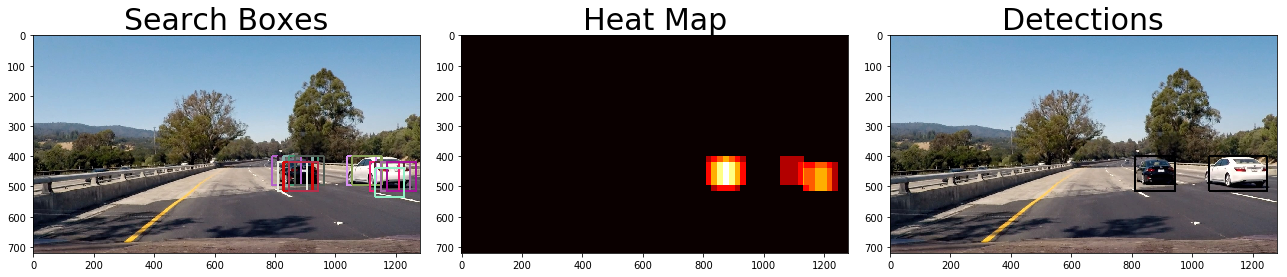

In [11]:
for img_num in range(4):
    
    test_img = mpimg.imread(test_images[img_num])
    
    
    # Sliding window
    windows =  fext.slide_window(test_img1,
                            x_start_stop=[600, None],
                            y_start_stop=[400, 656],
                            xy_window=(96,96),
                            xy_overlap=(.8,.8))
    
    # Scale image to match SVM training samples
    image = test_img.astype(np.float32)/255
    
    # Search windows
    box_list = fext.search_windows(image, windows, carSVMclf, X_scalerSVM, color_space, 
                   spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                   spatial_feat, hist_feat, hog_feat)

    detections_img = fext.draw_boxes(np.copy(image), box_list, random_color=True)
    
    # init heatmap
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = hmap.add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = hmap.apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    final_detections_img = hmap.draw_labeled_bboxes(np.copy(image), labels)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(detections_img)
    ax1.set_title('Search Boxes', fontsize=30)
    ax2.imshow(heat, cmap='hot')
    ax2.set_title('Heat Map', fontsize=30)
    ax3.imshow(final_detections_img)
    ax3.set_title('Detections', fontsize=30)
    image_name = 'output_images/heat_map{}.png'.format(img_num)
    plt.savefig(image_name, bbox_inches="tight")

After applying the heatmap, one can see a more robust detection from the combination of multiple detections and removal false positives using a threshold number of detections.

The final step is to implement all the functions above into a single function that can be call during the processing of images or video.

## 7. Pipeline and Video Processing

In [26]:
def pipeline(image):
    #carf.car_detection(img, scale =[1.1, 1.5, 1.9, 2.3],  heat_frames = 5, confidence_threshold = 0.3,
    #                heat_threshold = 2, window_size = 64) [1.0, 1.5, 2.0]
    detection_img = carf.car_detection(image, scale =[1.1, 1.5, 1.9, 2.3], heat_frames = 5, confidence_threshold = 0.3,
                    heat_threshold = 2, window_size = 64)
    
    return detection_img

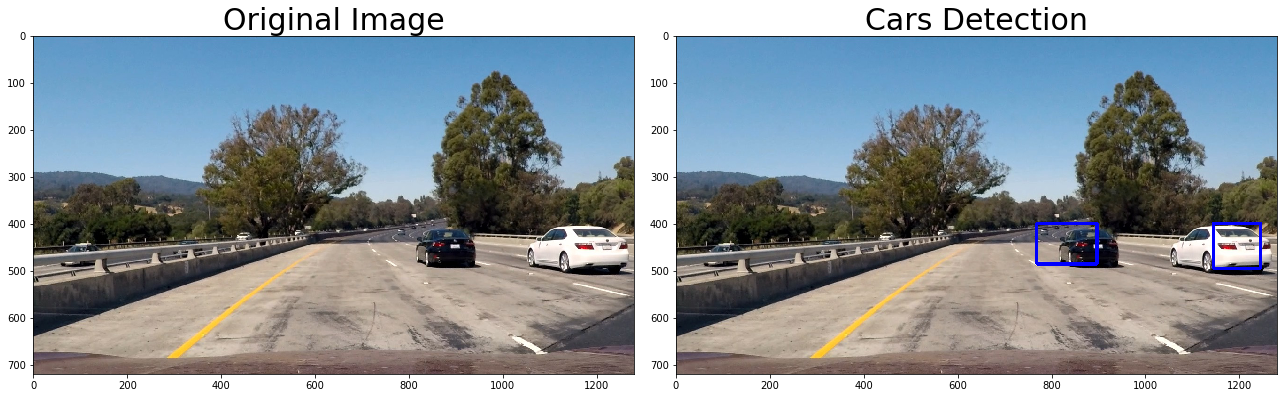

In [27]:
detections_img = pipeline(test_img1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
plt.tight_layout()
ax1.imshow(test_img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(detections_img)
ax2.set_title('Cars Detection', fontsize=30)
plt.savefig('output_images/pipeline_img.png', bbox_inches="tight")

After testing in an image, the pipeline can process video

In [28]:
def processVideo(video_file, video_file_output, image_process_pipeline):
    clip1 = VideoFileClip(video_file)
    project_clip = clip1.fl_image(image_process_pipeline) #NOTE: fl_image() expects color images
    %time project_clip.write_videofile(video_file_output, audio=False)

In [29]:
project_video = './test_videos/project_video.mp4'
project_video_output = './output_videos/project_video_output.mp4'

processVideo(project_video, project_video_output, pipeline)

[MoviePy] >>>> Building video ./output_videos/project_video_output.mp4
[MoviePy] Writing video ./output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [38:43<00:01,  1.82s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_output.mp4 

CPU times: user 37min 10s, sys: 1min 48s, total: 38min 59s
Wall time: 38min 44s


Show the processed video from the created pipeline

In [30]:
HTML("""
    <video width="960" height="540" controls>
    <source src="{0}">
    </video>

    """.format(project_video_output)
    )